In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *


from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-26 09:08:43.517531: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 09:08:44.861501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


### Now verify that mutual information estimates converge to the true value with increasing number of samples

100%|██████████| 3/3 [13:17<00:00, 265.75s/it]


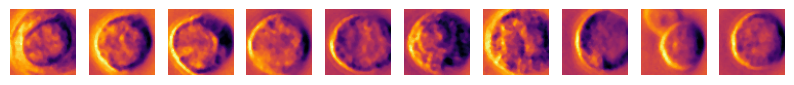

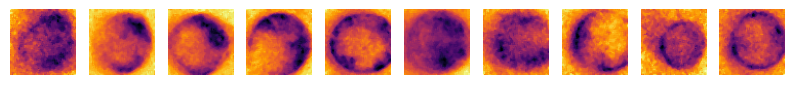

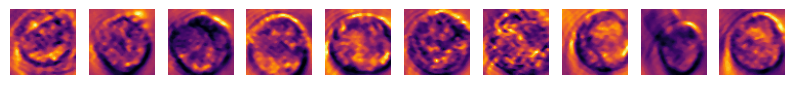

In [4]:
num_images = 10000
channels = ['DPC_Right', 'Brightfield', 'LED119']
# channels = ['LED119']
patch_size = 12
num_patches = 10000

images = {}
clean_patches_by_channel = {}
for channel in tqdm(channels):
    # load "clean" median filtered images
    images[channel] = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=32, median_filter=True)        
    clean_patches_by_channel[channel] = extract_patches(images[channel], patch_size, num_patches=num_patches)

    # plot a montage of images
    num_to_plot = 10
    fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
    for i in range(num_to_plot):
        ax[i].imshow(images[channel][i], cmap='inferno')
        ax[i].axis('off')

#### Compare conditional entropy of noisy to clean

In [14]:
mean_photons = {channel: np.mean(images[channel]) for channel in images.keys()}
photons_per_pixel_list = [5, 10, 20, 40, 80, 160, 320]
# photons_per_pixel_list = [40, 80, 160, 320]

num_bootstraps = 10
patch_size = 15
num_patches = 400
confidence_interval = 99

results = {}
for channel in channels:
    results[channel] = []
    for photons_per_pixel in tqdm(photons_per_pixel_list):
        rescale_fractions = {channel: photons_per_pixel / mean_photons[channel] for channel in images.keys()}
        clean_patches = clean_patches_by_channel[channel] * rescale_fractions[channel]
        noisy_patches = add_noise(clean_patches, ensure_positive=True)

        noisy_conditional_mean, noisy_conditional_interval = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                             lambda noisy_images: estimate_conditional_entropy(noisy_images))
        
        clean_conditional_mean, clean_conditional_interval = run_bootstrap(clean_patches, num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                                lambda clean_images: estimate_conditional_entropy(clean_images))
        
        noisy_conditional_mi_mean, noisy_conditional_mi_interval = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                             lambda noisy_images: estimate_mutual_information(noisy_images, verbose=False), verbose=True)

        clean_conditional_mi_mean, clean_conditional_mi_interval = run_bootstrap({'clean_patches': clean_patches, 'noisy_patches': noisy_patches},
                                                                                  num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                                lambda clean_patches, noisy_patches: estimate_mutual_information(noisy_patches, clean_patches, verbose=False), verbose=True)

        results[channel].append((noisy_conditional_mean, noisy_conditional_interval, clean_conditional_mean, clean_conditional_interval, noisy_conditional_mi_mean, noisy_conditional_mi_interval, clean_conditional_mi_mean, clean_conditional_mi_interval))
        

100%|██████████| 4/4 [33:51<00:00, 507.95s/it]


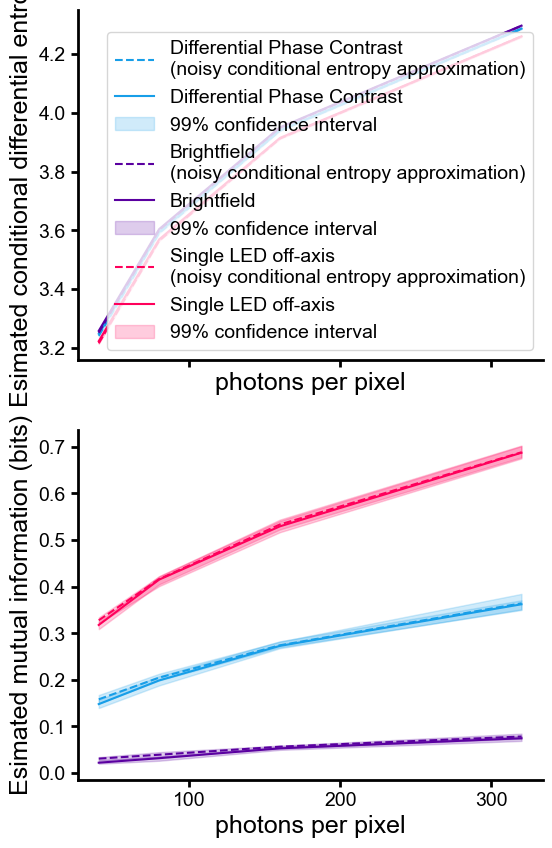

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), sharex=True)

colors = get_color_cycle()
for color, (channel, channel_results) in zip(colors, results.items()):
    noisy_conditional_means = []
    noisy_conditional_intervals = []
    clean_conditional_means = []
    clean_conditional_intervals = []
    noisy_conditional_mi_means = []
    noisy_conditional_mi_intervals = []
    clean_conditional_mi_means = []
    clean_conditional_mi_intervals = []
    for noisy_conditional_mean, noisy_conditional_interval, clean_conditional_mean, clean_conditional_interval, \
                noisy_conditional_mi_mean, noisy_conditional_mi_interval, clean_conditional_mi_mean, clean_conditional_mi_interval in channel_results:
        noisy_conditional_means.append(noisy_conditional_mean)
        noisy_conditional_intervals.append(noisy_conditional_interval)
        clean_conditional_means.append(clean_conditional_mean)
        clean_conditional_intervals.append(clean_conditional_interval)
        noisy_conditional_mi_means.append(noisy_conditional_mi_mean)
        noisy_conditional_mi_intervals.append(noisy_conditional_mi_interval)
        clean_conditional_mi_means.append(clean_conditional_mi_mean)
        clean_conditional_mi_intervals.append(clean_conditional_mi_interval)

    noisy_conditional_means = np.array(noisy_conditional_means)
    noisy_conditional_intervals = np.array(noisy_conditional_intervals)
    clean_conditional_means = np.array(clean_conditional_means)
    clean_conditional_intervals = np.array(clean_conditional_intervals)
    noisy_conditional_mi_means = np.array(noisy_conditional_mi_means)
    noisy_conditional_mi_intervals = np.array(noisy_conditional_mi_intervals)
    clean_conditional_mi_means = np.array(clean_conditional_mi_means)
    clean_conditional_mi_intervals = np.array(clean_conditional_mi_intervals)
    
    channel_name = get_display_channel_names(channel)


    ax[0].plot(photons_per_pixel_list, noisy_conditional_means, '--',label=channel_name + '\n(noisy conditional entropy approximation)', color=color)
    ax[0].fill_between(photons_per_pixel_list, noisy_conditional_intervals[:, 0], noisy_conditional_intervals[:, 1], alpha=0.2, 
                    color=color)
    ax[0].plot(photons_per_pixel_list, clean_conditional_means, '-', label=channel_name , color=color)
    ax[0].fill_between(photons_per_pixel_list, clean_conditional_intervals[:, 0], clean_conditional_intervals[:, 1], alpha=0.2, 
                    color=color, label=f'{confidence_interval}% confidence interval', )
    ax[0].set(xticks=[0, 100, 200, 300])

    ax[1].plot(photons_per_pixel_list, noisy_conditional_mi_means, '--',label=channel_name + '\n(noisy mutual information approximation)', color=color)
    ax[1].fill_between(photons_per_pixel_list, noisy_conditional_mi_intervals[:, 0], noisy_conditional_mi_intervals[:, 1], alpha=0.2, 
                    color=color)
    ax[1].plot(photons_per_pixel_list, clean_conditional_mi_means, '-', label=channel_name , color=color)
    ax[1].fill_between(photons_per_pixel_list, clean_conditional_mi_intervals[:, 0], clean_conditional_mi_intervals[:, 1], alpha=0.2, 
                    color=color, label=f'{confidence_interval}% confidence interval', )

clear_spines(ax[0])
clear_spines(ax[1])
ax[0].set(xlabel='photons per pixel', ylabel='Esimated conditional differential entropy')
ax[1].set(xlabel='photons per pixel', ylabel='Esimated mutual information (bits)')
ax[0].legend()